In [1]:
import anndata as ad
import crested
import numpy as np


2025-08-04 09:43:07.153578: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-04 09:43:07.727049: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754325787.944575 2014578 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754325788.015417 2014578 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-04 09:43:08.555470: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
import matplotlib
import matplotlib.pyplot as plt

# Set the font type to ensure text is saved as whole words
matplotlib.rcParams["pdf.fonttype"] = 42  # Use TrueType fonts instead of Type 3 fonts
matplotlib.rcParams["ps.fonttype"] = 42  # For PostScript as well, if needed

In [3]:
import os

genome_fasta  = "/allen/programs/celltypes/workgroups/rnaseqanalysis/references/human/10x/grch38.p2/genome/fasta/genome.fa"

# if you ever need a .chrom.sizes (for change_regions_width etc)
chr_sizes     = os.path.abspath(
    os.path.join(os.path.dirname(genome_fasta), "../star/chrNameLength.txt")
)

genome = crested.Genome(
   genome_fasta, chr_sizes)

crested.register_genome(
    genome
)  # Register the genome so that it can be used by the package

print(genome.fetch("chr1", 10000, 10010))

2025-08-04T09:43:27.792025-0700 INFO Genome genome registered.
TAACCCTAAC


In [4]:
adata = ad.read_h5ad("/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/OCTO/aibs-octo-dnaseq-modeling/basal-ganglia/models/crested/astrocytes/astro/dorsal_ventral_dars.h5ad")

# Modisco

In [5]:
# load a trained model
import keras

model_path = "/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/OCTO/aibs-octo-dnaseq-modeling/basal-ganglia/models/crested/astrocytes/astro/astro_human/cluster_full_universe_base_subset_filtered_dars/checkpoints/30.keras"
model = keras.models.load_model(model_path, compile=False)  # change to your model path

I0000 00:00:1754325808.176569 2014578 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38483 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:ca:00.0, compute capability: 8.0


In [6]:
# store predictions for all our regions in the anndata object for later inspection.
import pysam
from tqdm import tqdm
fasta = pysam.FastaFile(genome_fasta)

seqs = [
    fasta.fetch(chrom, start, end)
    for chrom, start, end in tqdm(zip(adata.var['chr'], adata.var['start'], adata.var['end']))
]


predictions = crested.tl.predict(seqs, model, verbose=2)
adata.layers["finetuned"] =predictions.T  # adata expects (C, N) instead of (N, C)

13171it [01:32, 142.00it/s]
I0000 00:00:1754325903.695633 2014883 service.cc:148] XLA service 0x7f85c0003280 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754325903.696001 2014883 service.cc:156]   StreamExecutor device (0): NVIDIA A100-PCIE-40GB, Compute Capability 8.0
2025-08-04 09:45:03.740687: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1754325903.841792 2014883 cuda_dnn.cc:529] Loaded cuDNN version 90600
2025-08-04 09:45:07.156326: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[256,512,1,1055]{3,2,1,0}, u8[0]{0}) custom-call(f32[256,512,1,1057]{3,2,1,0}, f32[512,512,1,3]{3,2,1,0}), window={size=1x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_s

103/103 - 46s - 442ms/step


In [7]:
adata_combined = adata.copy()  # Copy the peak heights
adata_combined.X = (
    adata_combined.X + adata_combined.layers["finetuned"]
) / 2  # Take the average with the predictions

In [8]:
# most informative regions per class
adata_filtered = adata_combined.copy()
top_k = 500  # Here we take the top 2k most specific regions, but doing this on top 500 or top 1k will give similar results and will be faster to calculate
crested.pp.sort_and_filter_regions_on_specificity(
    adata_filtered, top_k=top_k, method="proportion"
)
adata_filtered

2025-08-04T09:45:49.090808-0700 INFO After sorting and filtering, kept 1500 regions.


/home/niklas.kempynck/miniconda3/envs/crested_testing/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 3 × 1500
    obs: 'file_path'
    var: 'chr', 'start', 'end', 'split', 'Class name', 'rank', 'proportion_score'
    layers: 'finetuned'

In [9]:
from anndata import AnnData
import numpy as np
import pandas as pd
import scipy.sparse as sp


region_df = adata_filtered.var.reset_index()  # get 'region' as column
target_classes = region_df['Class name'].unique()

# Repeat var with same region index
repeated_var = pd.concat([
    region_df.assign(**{'Class name': cls}) for cls in target_classes
], ignore_index=True)

# Restore the region index (duplicated now!)
repeated_var.index = repeated_var['region']  # this is allowed

# Repeat X
X = adata_filtered.X
if sp.issparse(X):
    X = X.toarray()
X_repeated = np.tile(X, (1, len(target_classes)))  # repeat along columns

# Create new AnnData
adata_repeated = AnnData(
    X=X_repeated,
    obs=adata_filtered.obs.copy(),
    var=repeated_var
)

/home/niklas.kempynck/miniconda3/envs/crested_testing/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [10]:

adata_repeated.var['Class name'].value_counts()


Class name
Human-14    1500
Human-31    1500
Human-7     1500
Name: count, dtype: int64

chr                    chr18
start               23991622
end                 23993736
split                   test
Class name           Human-7
rank                     500
proportion_score    0.405139
Name: chr18:23991622-23993736, dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


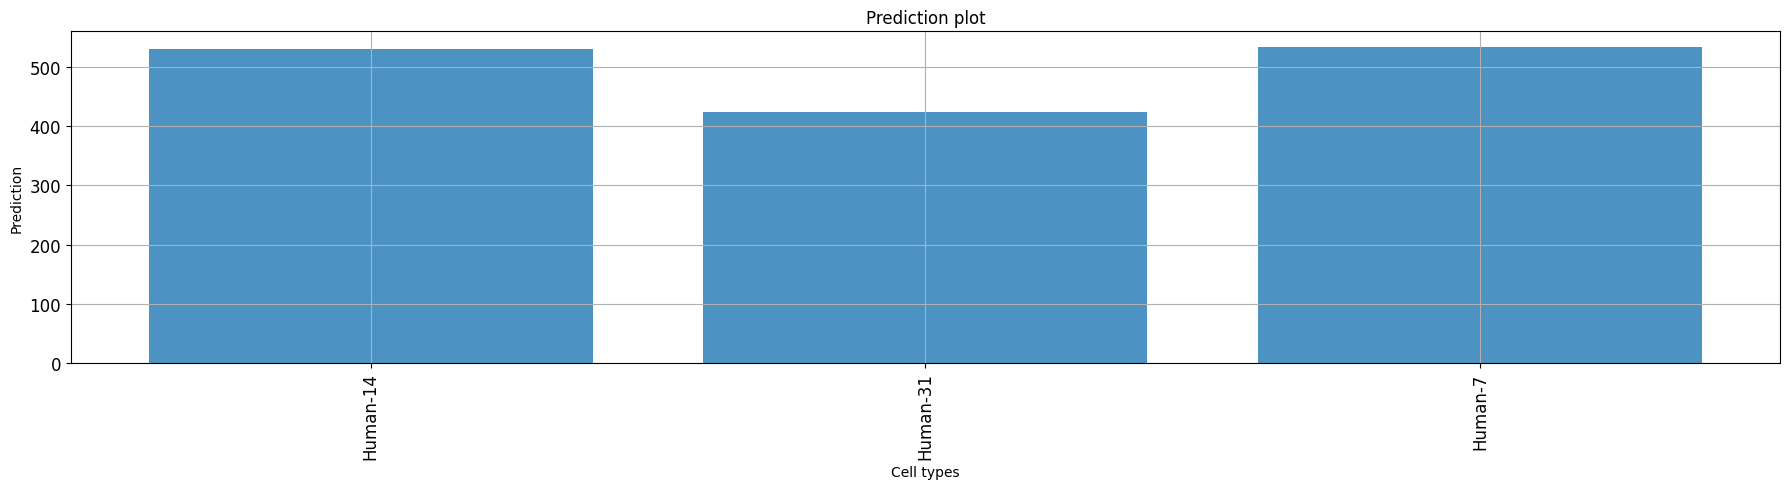

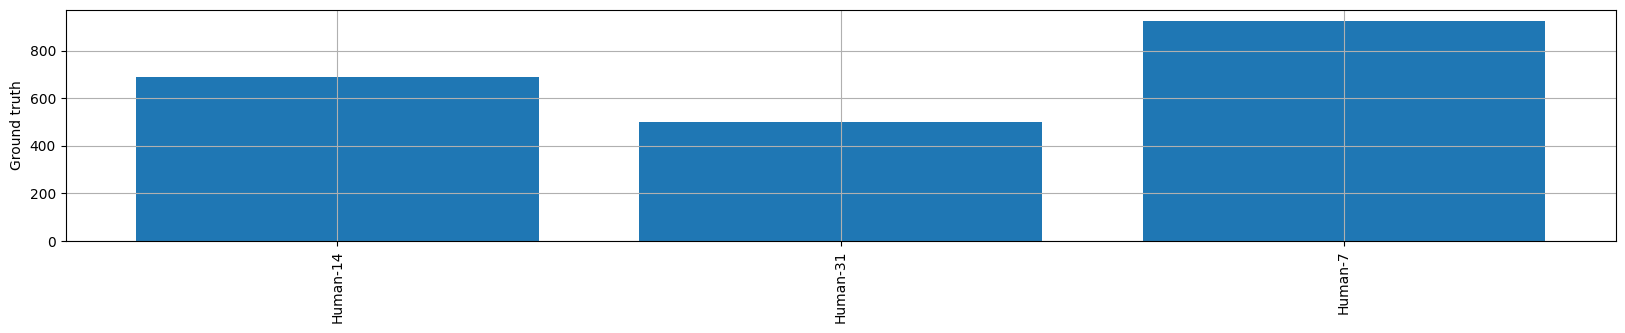

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
idx = 1499
reg = adata_filtered.var.iloc[idx]
print(reg)
chrom = reg['chr']
start = reg['start']
end = start+2114
seq_id = chrom+':'+str(start)+'-'+str(end)
sequence = genome.fetch(chrom, start, end)
prediction = crested.tl.predict(sequence, model)
crested.pl.bar.prediction(prediction, classes=list(adata.obs_names), x_label_rotation=90, height=5)
name = adata_filtered.var.index[idx]
reg_idx = adata.var_names.get_loc(name)
plt.figure(figsize=(20,3))
plt.bar(adata.obs_names, adata.X.T[reg_idx])
plt.xticks(rotation=90)
plt.ylabel('Ground truth')
plt.grid('on')

In [10]:
import numpy as np
cl_idx = int(np.argmax(prediction))
class_= np.array(list(adata.obs_names))
class_idx = list(adata.obs_names.get_indexer(class_))

scores, one_hot_encoded_sequences = crested.tl.contribution_scores(
    sequence,
    target_idx=class_idx,  # None (=all classes), list of target indices, or empty list (='combined' class)
    model=model,
    method="integrated_grad",  # default. Other options: "integrated_grad", "mutagenesis"
)

2025-08-03T19:51:12.994647-0700 INFO Calculating contribution scores for 3 class(es) and 1 region(s).


Model: 100%|██████████| 1/1 [00:08<00:00,  8.33s/it]


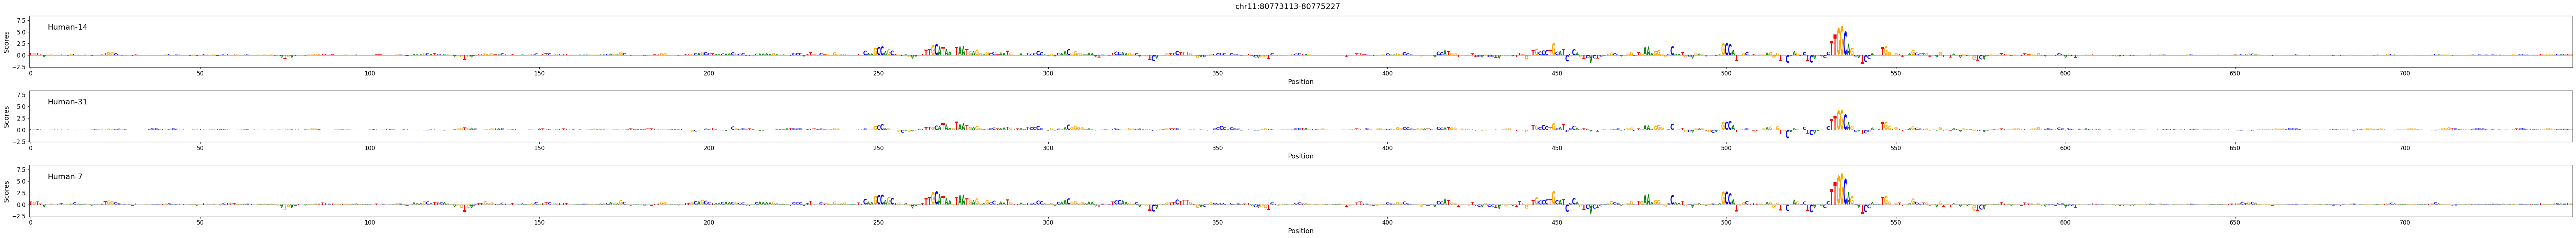

In [11]:
%matplotlib inline
crested.pl.patterns.contribution_scores(
    scores,
    one_hot_encoded_sequences,
    sequence_labels=[""],
    class_labels=list(class_),
    zoom_n_bases=750,
    title=seq_id,
    height=7
)  # zoom in on the center 500bp

## Per cluster

In [23]:
crested.tl.contribution_scores_specific(
    input=adata_repeated,
    target_idx=None,  # We calculate for all classes
    model=model,
    method='integrated_grad',
    output_dir="/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/OCTO/aibs-octo-dnaseq-modeling/basal-ganglia/models/crested/astrocytes/astro/dorsal_ventral/patterns/combined_modisco_results_ft_500/",
    verbose=True
)

2025-08-03T20:48:07.415003-0700 INFO Calculating contribution scores for 1 class(es) and 1500 region(s).


Model: 100%|██████████| 1/1 [01:58<00:00, 118.66s/it]


2025-08-03T20:50:19.236215-0700 INFO Calculating contribution scores for 1 class(es) and 1500 region(s).


Model: 100%|██████████| 1/1 [01:58<00:00, 118.49s/it]


2025-08-03T20:52:30.746538-0700 INFO Calculating contribution scores for 1 class(es) and 1500 region(s).


Model: 100%|██████████| 1/1 [01:58<00:00, 118.63s/it]


(array([[[[-6.78257902e-06,  9.82886104e-06, -1.04089359e-05, ...,
            1.99467322e-04,  2.56954409e-05,  5.25724354e-05],
          [ 5.65224291e-05, -2.43792238e-05,  4.05596220e-05, ...,
           -1.06544510e-04, -1.05731830e-04, -2.90475236e-06],
          [-2.11453953e-05,  4.94870028e-06, -7.83648211e-05, ...,
           -8.60796281e-05,  1.87381534e-04,  3.08108611e-06],
          [-2.56575895e-05,  3.86306310e-05,  6.94007540e-05, ...,
            9.52830815e-05, -7.41562280e-06,  4.12933732e-05]]],
 
 
        [[[ 5.82668736e-06,  1.80706047e-05, -7.35184403e-06, ...,
           -3.88675864e-04, -6.20844512e-05,  2.42575716e-05],
          [-1.11077306e-05,  6.72393753e-06, -1.27334415e-05, ...,
            2.09069447e-04,  1.46197955e-04, -4.56611488e-05],
          [-4.70277064e-06, -8.20051901e-06, -2.23319989e-06, ...,
            1.30847126e-04,  6.61255763e-05, -3.80212441e-05],
          [ 1.90224564e-05, -1.49447833e-05,  2.92908389e-05, ...,
            7.153

In [24]:
meme_db, motif_to_tf_file = crested.get_motif_db()

In [25]:
import os
os.environ["PATH"] = "/home/niklas.kempynck/meme/bin:" + os.environ["PATH"]

In [ ]:
# run tfmodisco on the contribution scores
crested.tl.modisco.tfmodisco(
    window=1000,
    output_dir="/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/OCTO/aibs-octo-dnaseq-modeling/basal-ganglia/models/crested/astrocytes/astro/dorsal_ventral/patterns/combined_modisco_results_ft_500/",
    contrib_dir="/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/OCTO/aibs-octo-dnaseq-modeling/basal-ganglia/models/crested/astrocytes/astro/dorsal_ventral/patterns/combined_modisco_results_ft_500/",
    report=True,  # Optional, will match patterns to motif MEME database
    meme_db=meme_db,  # File to MEME database
    max_seqlets=20000,
)

2025-08-03T20:54:42.520754-0700 INFO No class names provided, using all found in the contribution directory: ['Human-14', 'Human-31', 'Human-7']
2025-08-03T20:54:43.052809-0700 INFO Running modisco for class: Human-14
Using 5023 positive seqlets


# Combined modisco run

In [13]:
import numpy as np

# Load the .npz files
seqs1 = '/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/OCTO/aibs-octo-dnaseq-modeling/basal-ganglia/models/crested/astrocytes/astro/dorsal_ventral/patterns/combined_modisco_results_ft_500//Human-14_oh.npz'
seqs2 = '/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/OCTO/aibs-octo-dnaseq-modeling/basal-ganglia/models/crested/astrocytes/astro/dorsal_ventral/patterns/combined_modisco_results_ft_500/Human-31_oh.npz'
seqs3 = '/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/OCTO/aibs-octo-dnaseq-modeling/basal-ganglia/models/crested/astrocytes/astro/dorsal_ventral/patterns/combined_modisco_results_ft_500/Human-7_oh.npz'

contribs1 = '/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/OCTO/aibs-octo-dnaseq-modeling/basal-ganglia/models/crested/astrocytes/astro/dorsal_ventral/patterns/combined_modisco_results_ft_500/Human-14_contrib.npz'
contribs2 = '/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/OCTO/aibs-octo-dnaseq-modeling/basal-ganglia/models/crested/astrocytes/astro/dorsal_ventral/patterns/combined_modisco_results_ft_500/Human-31_contrib.npz'
contribs3 = '/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/OCTO/aibs-octo-dnaseq-modeling/basal-ganglia/models/crested/astrocytes/astro/dorsal_ventral/patterns/combined_modisco_results_ft_500//Human-7_contrib.npz'

# List your .npz files
npz_files = [seqs1, seqs2, seqs3]
contrib_files = [contribs1, contribs2, contribs3]

# Load all files into a list of dictionaries
loaded = [np.load(f) for f in npz_files]
loaded_contribs = [np.load(f) for f in contrib_files]


# Check that all keys match across files
all_keys = [set(f.files) for f in loaded]
all_keys_contribs = [set(f.files) for f in loaded]

if not all(k == all_keys[0] for k in all_keys):
    raise ValueError("Not all .npz files have the same keys!")

# Concatenate each key
combined = {
    key: np.concatenate([f[key] for f in loaded], axis=0)
    for key in all_keys[0]
}
combined_contrib = {
    key: np.concatenate([f[key] for f in loaded_contribs], axis=0)
    for key in all_keys_contribs[0]
}

# Save to new .npz
np.savez('/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/OCTO/aibs-octo-dnaseq-modeling/basal-ganglia/models/crested/astrocytes/astro/dorsal_ventral/patterns/combined_modisco/combined_oh.npz', **combined)
np.savez('/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/OCTO/aibs-octo-dnaseq-modeling/basal-ganglia/models/crested/astrocytes/astro/dorsal_ventral/patterns/combined_modisco/combined_contrib.npz', **combined_contrib)

In [15]:
import os
os.environ["PATH"] = "/home/niklas.kempynck/meme/bin:" + os.environ["PATH"]
meme_db, motif_to_tf_file = crested.get_motif_db()

In [ ]:
# run tfmodisco on the contribution scores
crested.tl.modisco.tfmodisco(
    window=1000,
    output_dir="/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/OCTO/aibs-octo-dnaseq-modeling/basal-ganglia/models/crested/astrocytes/astro/dorsal_ventral/patterns/combined_modisco/",
    contrib_dir="/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/OCTO/aibs-octo-dnaseq-modeling/basal-ganglia/models/crested/astrocytes/astro/dorsal_ventral/patterns/combined_modisco/",
    report=True,  # Optional, will match patterns to motif MEME database
    meme_db=meme_db,  # File to MEME database
    max_seqlets=20000,
)

2025-08-04T09:50:17.136996-0700 INFO No class names provided, using all found in the contribution directory: ['combined']
2025-08-04T09:50:17.635850-0700 INFO Running modisco for class: combined
Using 12149 positive seqlets
